In [1]:
# General imports
from pathlib import Path
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Create solution folder
Path("solution/").mkdir(exist_ok=True)

## Neural Network Class
In this task we implement the building blocks of a simple neural network class.

For simplicity's sake, this class will only allow feed forward networks.
All individual operations, including activation functions, will be represented as layers in this model.
The abstract `Layer` interface defines three methods:

In [2]:
class Layer:
    def forward(self, x):
        """Forward pass of the layer.
        For convenience, input and output are stored in the layer. 

        Args:
            x: Input for this layer. Shape is (batch_size, num_inputs).

        Returns:
            x: Output of this layer. Shape is (batch_size, num_outputs).
        """
        raise NotImplementedError

    def backward(self, gradient):
        """Backward pass of the layer.
        The incoming gradients are stored in the layer. 

        Args:
            gradient: Incoming gradient from the next layer. Shape is (batch_size, num_outputs).

        Returns:
            gradient: Gradient passed to previous layer. Shape is (batch_size, num_inputs).
        """
        raise NotImplementedError

    def update(self, learn_rate):
        """Perform weight update based on previously stored input and gradients.

        Args:
            learn_rate: Learn rate to use for the update.
        """

### a) Linear Layer

In [3]:
class LinearLayer(Layer):
    def __init__(self, input_dim, output_dim, seed=None):
        """Initialize the layer with random weights."""
        # Initialize weights with the He initializer
        rnd = np.random.RandomState(seed).randn(input_dim, output_dim)
        self.w = rnd * (2 / input_dim) 
        
        # Initialize bias with zeros
        self.b = np.zeros(output_dim)
        
    def forward(self, x):
        """Forward pass of the layer."""
        self.input = x # Store input
        # Compute output
        x = x @ self.w + self.b.T
        self.output = x # Store output
        return x
    
    def backward(self, gradient):
        """Backward pass of the layer."""
        self.gradient = gradient # Store incoming gradient
        # Apply transfer gradient
        gradient = self.gradient @ self.w.T
        return gradient
    
    def update(self, learn_rate):
        """Perform weight update"""
        # Update weights and bias
        self.w = self.w - learn_rate * self.input.T @ self.gradient 
        self.b = self.b - learn_rate * self.gradient[0]

In [4]:
# Test code
_test_layer = LinearLayer(4, 5, seed=42)

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward(np.ones((1, 4))), [[-0.38156401, -0.01880618,  0.98566644, -0.88387442, -1.41440743]])

# Test backward pass
np.testing.assert_array_almost_equal(_test_layer.backward(np.ones((1, 5))), [[1.147507,  1.092798, -2.162692, -1.7906 ]])

# Test update
_test_layer.update(0.1)
np.testing.assert_array_almost_equal(_test_layer.w, [[ 0.148357, -0.169132,  0.223844,  0.661515, -0.217077], [-0.217068,  0.689606,  0.283717, -0.334737,  0.17128 ], [-0.331709, -0.332865,  0.020981, -1.05664 , -0.962459], [-0.381144, -0.606416,  0.057124, -0.554012, -0.806152]])
np.testing.assert_array_almost_equal(_test_layer.b, [-0.1, -0.1, -0.1, -0.1, -0.1])
"ok"

'ok'

### b) Implementing ReLU

In [5]:
class ReLULayer(Layer):      
    def forward(self, x):
        """Forward pass of the ReLU layer."""
        self.input = x # Store input
        
        # Compute output
        x = np.multiply(x, (x>0))
        
        self.output = x # Store output
        return x
    
    def backward(self, gradient):
        """Backward pass of the ReLU layer."""
        self.gradient = gradient # Store incoming gradient
        
        # Apply transfer gradient
        gradient = np.multiply(gradient, (self.output>0))
        
        return gradient

In [6]:
# Test Code
_test_layer = ReLULayer()

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward(np.arange(5)-2), [0, 0,  0, 1, 2])

# Test backward pass
assert np.array_equal(_test_layer.backward(np.ones(5)), [0, 0, 0, 1, 1]) or np.array_equal(_test_layer.backward(np.ones(5)), [0, 0, 1, 1, 1]), f"backward expected {[0, 0, 1, 1, 1]} or {[0, 0, 0, 1, 1]}, but got {_test_layer.backward(np.ones(5))}"

"ok"

'ok'

### c) Softmax Layer

In [7]:
    class SoftmaxLayer(Layer):
        def forward(self, x):
            """Forward pass of the softmax layer."""
            self.input = x  # Store input
  
            # Compute output
            e_x = np.exp(x)
            x = e_x / e_x.sum()
            x = np.nan_to_num(x, nan=1)

            self.output = x  # Store output
            return x


In [8]:
# Test code
_test_layer = SoftmaxLayer()

# Test forward pass
np.testing.assert_array_almost_equal(_test_layer.forward([[1, 1]]), [[0.5, 0.5]])
np.testing.assert_array_almost_equal(_test_layer.forward([[1, 2, 3]]), [[0.09003057, 0.24472847, 0.66524096]])
np.testing.assert_array_almost_equal(_test_layer.forward([[0, 1, 2]]), [[0.09003057, 0.24472847, 0.66524096]])
np.testing.assert_array_almost_equal(_test_layer.forward([[0]]), [[1]])
np.testing.assert_array_almost_equal(_test_layer.forward([[0, 10, 100, 1e6]]), [[0, 0, 0, 1]], err_msg="Overflow")

"ok"

C:\Users\rites\AppData\Local\Temp\ipykernel_21068\1712501927.py:9: RuntimeWarning: overflow encountered in exp
  e_x = np.exp(x)
C:\Users\rites\AppData\Local\Temp\ipykernel_21068\1712501927.py:10: RuntimeWarning: invalid value encountered in true_divide
  x = e_x / e_x.sum()


'ok'

### d) Completing the Network

In [9]:
class FeedForwardNet:
    def __init__(self, layers):
        self.layers = layers
    
    def forward(self, x):
        """Forward pass through the entire network."""
        # Compute output
        for i in range(len(self.layers)):
            x = self.layers[i].forward(x)
        
        
        
        # ********************
        return x
    
    def backward(self, gradient):
        """Backward pass through the entire network."""
        # Back propagate gradients through all layers
        for i in range(len(self.layers)):
            gradient = self.layers[len(self.layers) - 1 - i].backward(gradient)

        
        
        # ********************

    def train(self, x, target, learn_rate):
        """Train one batch."""
        gradient = self.forward(x) - target  # Assumes quadratic loss function
        self.backward(gradient)  # Backprop
        # print(gradient)
        # Update weights in all layers
        for layer in self.layers:
            layer.update(learn_rate)
        

In [10]:
# Test Code
_test_net = FeedForwardNet([LinearLayer(4, 10, seed=0),
                      ReLULayer(),
                      LinearLayer(10, 3, seed=1),
                      SoftmaxLayer(),
                     ])
np.testing.assert_array_almost_equal(_test_net.forward([1,2,3,4]), [0.27760362, 0.64002456, 0.08237182])
"ok"

'ok'

## Autoencoder on MNIST

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST\raw\train-labels-idx1-ubyte.gz to data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-images-idx3-ubyte.gz to data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST\raw\t10k-labels-idx1-ubyte.gz to data/MNIST\raw



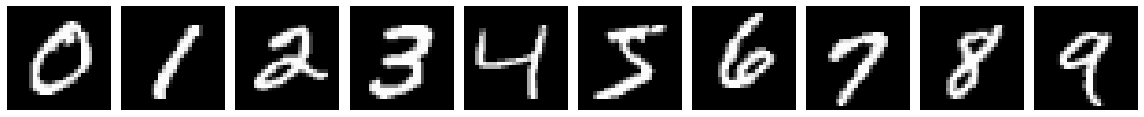

In [11]:
import torch
import torchvision
from torchvision import transforms

# Load MNIST dataset
mnist = torchvision.datasets.MNIST(root='data/', download=True, transform=transforms.ToTensor())
mnist_test = np.array([x.numpy() for x, y in torchvision.datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor())]).reshape(-1, 28, 28)
data_loader = torch.utils.data.DataLoader(mnist, batch_size=32, shuffle=True)

# Show examples
plt.figure(figsize=(16,2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    
    # Choose first example with the corresponding digit
    example = next(x for x, y in mnist if y == i).reshape(28, 28)
    plt.imshow(example, cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()

### a) Build the Autoencoder

In [12]:
# Build autoencoder
autoencoder = FeedForwardNet([LinearLayer(784, 235),
                      ReLULayer(),
                      LinearLayer(235,80),
                      ReLULayer(),
                      LinearLayer(80, 16),
                      LinearLayer(16, 80),
                      ReLULayer(),
                      LinearLayer(80, 235),
                      ReLULayer(),
                      LinearLayer(235, 784)         
                     ])

In [13]:
# Test Code
assert all(type(l) in [LinearLayer, ReLULayer] for l in autoencoder.layers), "Only use Linear and ReLu layers"
assert autoencoder.layers[0].w.shape[0] == 784, "Wrong size of input"
assert autoencoder.layers[-1].w.shape[1] == 784, "Wrong size of output"
assert min(l.w.shape[0] for l in autoencoder.layers if type(l) == LinearLayer) == 16, "Wrong size of the bottleneck"

"ok"

'ok'

### b) Train the Autoencoder

The Autoencoder is trained on the MNIST dataset via minibatch gradient descend.

The incoming batches of images have a shape of (batch_size, 28, 28). To process them in a linear layer, we reshape them to (batch_size, 28 * 28).
Then, use the `train` method of the implemented `FeedForwardNetwork` to train the batch.

  0%|          | 0/50 [00:00<?, ?it/s]

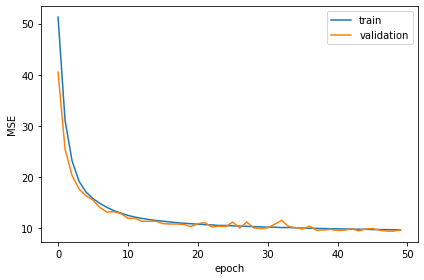

In [14]:
epochs = 50

losses = np.empty((epochs, 2))
with tqdm(range(epochs)) as pbar:
    for epoch in pbar:
        running_loss = 0.0
        for batch, _ in data_loader:
            # ********************
            # Reshape and train batch
             I, J, D, D = batch.shape
            # Training the Autoencoder
             learn_rate = 0.7e-3
             batch = np.array(batch).reshape([-1, D*D])
             autoencoder.train(batch, batch, learn_rate)
            
            # ********************

             running_loss += np.sum((autoencoder.layers[-1].output - batch)**2)
        
        # Log losses and update progress bar
        train_loss = running_loss/len(mnist)
        validation_loss = np.sum(np.mean((autoencoder.forward(mnist_test.reshape(-1, 28*28))-mnist_test.reshape(-1, 28*28))**2, axis=0))
        losses[epoch] = [train_loss, validation_loss]
        pbar.set_description(f"Loss {train_loss:.02f}/{validation_loss:.02f}")

# Save model
with open("solution/a2b.pickle", "wb") as f:
    pickle.dump(autoencoder, f)

# Visualize losses
losses = np.array(losses)
plt.plot(np.arange(len(losses)), losses[:,0], label="train")
plt.plot(np.arange(len(losses)), losses[:,1], label="validation")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.tight_layout()
plt.savefig("solution/a2b-train.png")

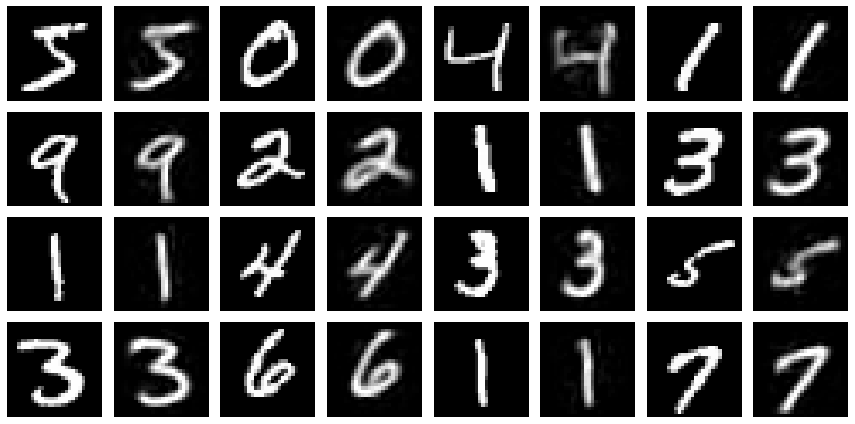

In [15]:
# Show reconstruction
plt.figure(figsize=(12,6))
for i in range(16):
    # Show image
    plt.subplot(4,8,2*i+1)
    plt.imshow(mnist[i][0].reshape((28,28)), cmap="gray")
    plt.axis("off")

    # Show reconstruction
    plt.subplot(4,8, 2*i+2)
    plt.imshow(autoencoder.forward(mnist[i][0].reshape(28*28)).reshape(28,28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()
plt.savefig("solution/a2b-rec.png")

### c) Interpolation

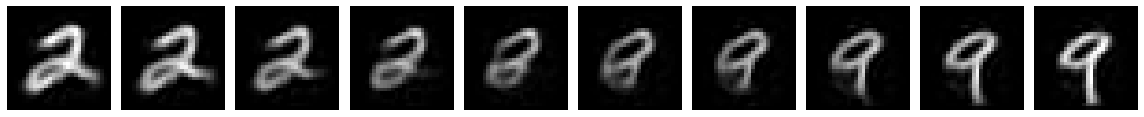

In [17]:
# Split the autoencoder at the bottleneck into encoder and decoder 
encoder = FeedForwardNet(autoencoder.layers[:3])
decoder = FeedForwardNet(autoencoder.layers[3:])

#  Choose two images 
image_a = mnist[5][0]
image_b = mnist[4][0]

# Compute their latent representations
latent_a = encoder.forward(image_a.reshape(28*28))
latent_b = encoder.forward(image_b.reshape(28*28))


steps=10
plt.figure(figsize=(16,2))
for i, f in enumerate(np.linspace(0, 1, steps)):
    plt.subplot(1, steps, i+1)
    
    #Interpolate the latent values
    latent = (1-f)*latent_a + f*latent_b
    
    plt.imshow(decoder.forward(latent).reshape(28, 28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()
plt.savefig("solution/a2c.png")

### d) Latent space sampling

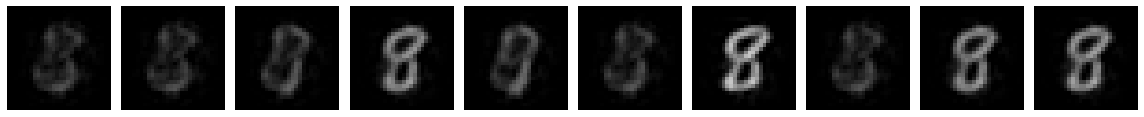

In [19]:
# Compute mean and std of latent states
latent_space = encoder.forward(mnist_test.reshape(-1, 28*28))
latent_space_mean = np.mean(latent_space, axis=0)
latent_space_std = np.std(latent_space, axis=0)

# Sample from latent distribution
plt.figure(figsize=(16,2))
for i, f in enumerate(np.linspace(0,1,steps)):
    plt.subplot(1, steps, i+1)
    
    # Sample from the normal distribution with latent_space_mean and latent_space_std
    epsilon = np.random.normal(0,1)
    latent = latent_space_mean + latent_space_std * epsilon
    
    plt.imshow(decoder.forward(latent).reshape(28, 28), cmap="gray", vmin=0, vmax=1)
    plt.axis("off")
plt.tight_layout()
plt.savefig("solution/a2d.png")